In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_squared_error
from collections import defaultdict
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from tqdm import tqdm, trange

#read in data
ratings = pd.read_csv("C:/Users/Sunny/Desktop/ml/219 Large Scale Data Mining Model and Algorithms/Project3/ratings.csv")
movies = pd.read_csv("C:/Users/Sunny/Desktop/ml/219 Large Scale Data Mining Model and Algorithms/Project3/movies.csv")
tags = pd.read_csv("C:/Users/Sunny/Desktop/ml/219 Large Scale Data Mining Model and Algorithms/Project3/tags.csv")
links = pd.read_csv("C:/Users/Sunny/Desktop/ml/219 Large Scale Data Mining Model and Algorithms/Project3/links.csv")
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

2



  4%|███▎                                                                               | 1/25 [00:11<04:27, 11.14s/it]

4



  8%|██████▋                                                                            | 2/25 [00:23<04:26, 11.59s/it]

6



 12%|█████████▉                                                                         | 3/25 [00:36<04:34, 12.49s/it]

8



 16%|█████████████▎                                                                     | 4/25 [00:51<04:40, 13.37s/it]

10



 20%|████████████████▌                                                                  | 5/25 [01:06<04:40, 14.02s/it]

12



 24%|███████████████████▉                                                               | 6/25 [01:22<04:41, 14.80s/it]

14



 28%|███████████████████████▏                                                           | 7/25 [01:39<04:38, 15.46s/it]

16



 32%|██████████████████████████▌                                                        | 8/25 [01:56<04:29, 15.84s/it]

18



 36%|█████████████████████████████▉                                                     | 9/25 [02:13<04:22, 16.38s/it]

20



 40%|████████████████████████████████▊                                                 | 10/25 [02:31<04:12, 16.84s/it]

22



 44%|████████████████████████████████████                                              | 11/25 [02:52<04:11, 17.98s/it]

24



 48%|███████████████████████████████████████▎                                          | 12/25 [03:11<04:00, 18.48s/it]

26



 52%|██████████████████████████████████████████▋                                       | 13/25 [03:32<03:48, 19.06s/it]

28



 56%|█████████████████████████████████████████████▉                                    | 14/25 [03:53<03:36, 19.71s/it]

30



 60%|█████████████████████████████████████████████████▏                                | 15/25 [04:14<03:22, 20.21s/it]

32



 64%|████████████████████████████████████████████████████▍                             | 16/25 [04:37<03:07, 20.83s/it]

34



 68%|███████████████████████████████████████████████████████▊                          | 17/25 [05:00<02:51, 21.46s/it]

36



 72%|███████████████████████████████████████████████████████████                       | 18/25 [05:23<02:33, 21.98s/it]

38



 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [05:47<02:15, 22.56s/it]

40



 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [06:11<01:55, 23.15s/it]

42



 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [06:37<01:35, 23.86s/it]

44



 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [07:03<01:14, 24.67s/it]

46



 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [07:30<00:50, 25.17s/it]

48



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [07:57<00:25, 25.83s/it]

50


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [08:25<00:00, 20.24s/it]


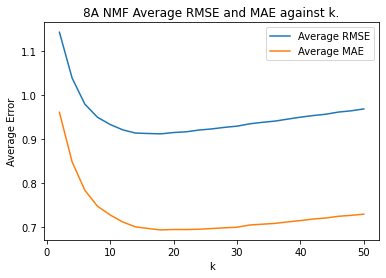

In [2]:
########Question 8
####Part A
minimum_rmse = 1e4
minimum_mae = 1e4
K_minimum_rmse= 0
average_rmse = []
average_mae = []

#create a new k of step size 2
new_k = np.arange(2,52,2) 
for l in trange(len(new_k)):
    k1 = new_k[l]
    nmf = NMF(n_factors = k1)
    #create cross_validation fold
    cv = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)  
    #value for MAR
    MAE = np.mean(cv["tmae"])
    average_mae.append(MAE)
    minimum_mae, k_minimum_mae = (MAE, k1) if MAE < 1e4 else (minimum_mae, k_minimum_mae)
    #for RMSE    
    RMSE = np.mean(cv["trmse"])
    average_rmse.append(RMSE)
    if RMSE < 1e4:
        minimum_rmse = RMSE
        k_minimum_rmse = k1

plt.plot(new_k, average_mae, label="Average MAE")
plt.plot(new_k, average_rmse, label="Average RMSE")
plt.xlabel("K")
plt.ylabel("Average Error")

In [5]:
######8b
print("Q 8B")
print(f"Minimum Average RMSE = {minimum_rmse:.3f}, k = {k_minimum_rmse}")
print(f"Minimum Average MAE = {minimum_mae:.3f}, k = {k_minimum_mae}")

Question8B
Minimum Average RMSE (NMF) = 0.967, k = 50
Minimum Average MAE (NMF) = 0.693, k = 22


In [6]:
###########8c
def nmf_roc(train_dataset, test_dataset, bestk, title):
    threshold = [2.5, 3.0, 3.5, 4.0]
    hold  = NMF(n_factors=bestk,n_epochs=30,verbose=False).fit(train_dataset).test(test_dataset)
    for num in threshold:
        thre_output = []
        for row in hold:
            if row.r_ui < num:
                thre_output.append(0)
            else:
                thre_output.append(1)
    FPR, TPR, thresholds = roc_curve(thre_output, [row.est for row in hold])
    labels = f"AUC: {auc(FPR,TPR):.3f} , threshold: {num}"
    plt.plot(FPR, TPR,lw=2, label=labels) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show() 
    
#Find the miminum k value for MAE and RMSE
def min_k(title, average_rmse, ks):
    eps = 1e-3
    bestk = -1
    for l in range(len(ks)-1):         
        if(abs(average_rmse[i]-average_rmse[i+1])<eps):
            print(f"{title} Minimum k for RMSE is {ks[l]}, average RMSE is {average_rmse[l]:.3f}")
            bestk = ks[l]
            break    
    return bestk

#rating result
def nmf_result(ratings, filter, title, ks):
    filter_ratings = ratings[ratings.apply(filter, axis=1)]
    data = Dataset.load_from_df(filter_ratings[['userId','movieId','rating']], reader=reader)
    
    rmse_min = 1e3
    rmse_min_k = ks[-1]
    
    average_rmse = []
    

    for k in ks:
        iter = 1
        RMSE = 0
        for train_dataset, test_dataset in kf.split(data):
            print(f"iter={iter}", end=",")
            iter = iter + 1
            perf = NMF(n_factors=k,n_epochs=30,verbose=False).fit(train_dataset).test(test_dataset)
            RMSE = RMSE + accuracy.RMSE(perf,verbose=False)
        
        rmse_min_k = k if RMSE < rmse_min else rmse_min_k
        rmse_min = RMSE if RMSE < rmse_min else rmse_min
        average_rmse.append(RMSE / 10.0)

        
        
    def 
        plot_k(title, average_rmse, ks):
        plt.plot(ks,average_rmse)
        plt.ylabel('Average RMSE')
        plt.xlabel('k')

    plot_k(title, average_rmse,ks)
    bestk = min_k(title, average_rmse,ks)
    nmf_roc(train_dataset, test_dataset, best_k,title)

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

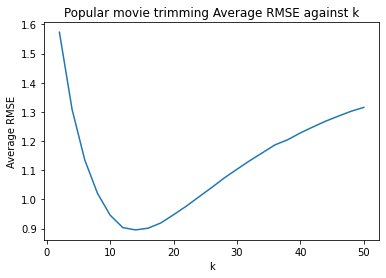

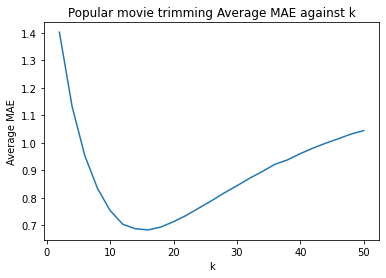

no convergence, we just choose a k with min rmse


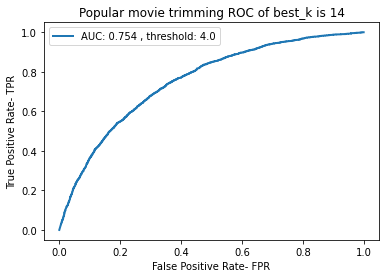

In [7]:
#popular trim
def popular_trim(row):
    return len(ref[row['movieId']]) > 2
kf = KFold(n_splits=10)
ref = defaultdict(list)
for _, row in ratings.iterrows():
    ref[row['movieId']].append(row['rating'])
nmf_result(ratings, popular_trim, "Popular movie trim", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

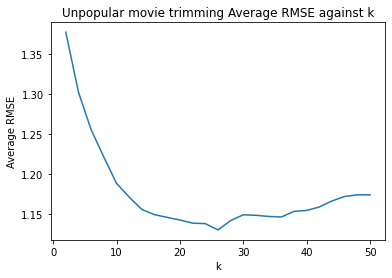

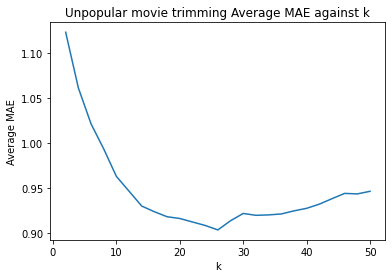

Unpopular movie trimming Minimum k for RMSE is 22, average RMSE is 1.139
Unpopular movie trimming Minimum k for MAE is 32, average MAE is 0.920


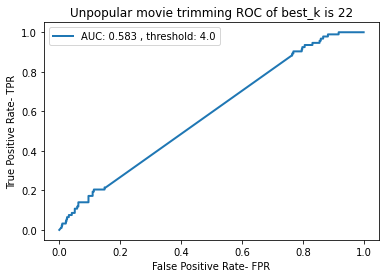

In [8]:
#unpopular trimming
def unpopular_trim(row):
    return len(ref[row['movieId']]) <= 2
nmf_result(ratings, unpopular_trim, "Unpopular movie trimming", ks=np.arange(2,52,2))

k=2:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=4:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=6:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=8:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=10:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=12:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=14:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=16:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=18:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=20:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=22:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=24:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=26:iter=1,iter=2,iter=3,iter=4,iter=5,iter=6,iter=7,iter=8,iter=9,iter=10,
k=2

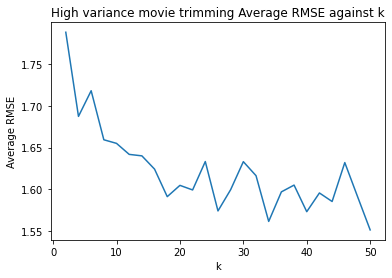

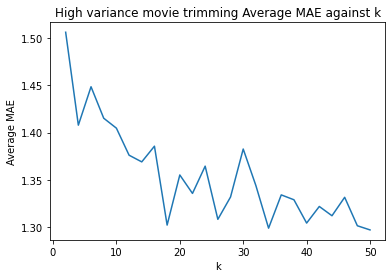

no convergence, we just choose a k with min rmse


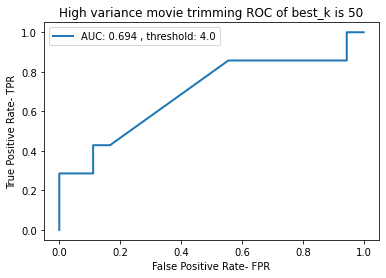

In [9]:
#high variance trimming
data = ratings.pivot_table('rating', 'userId', 'movieId')
variance = np.var(data, axis=0)
def high_variance_trimming(row):
    return len(ref[row['movieId']]) >= 5 and row['movieId'] in variance[variance>=2].keys()
nmf_result(ratings, high_variance_trimming, "High variance movie trimming", ks=np.arange(2,52,2))

In [28]:
#######Question 9
for train_dataset, test_dataset in kf.split(data):
          print(f"iter={iter}", end=",")
def report_roc(train_dataset, test_dataset, best_k, title):
    Threshold_list = [2.5, 3.0, 3.5, 4.0]
    hold  = KNNWithMeans(k=best_k,sim_options={'name':'pearson'},verbose=False).fit(train_dataset).test(test_dataset)
#for movie -letent factor K=20
nmf_k20 = NMF(n_factors=20,n_epochs=30,verbose=False)
nmf_k20.fit(train_dataset).test(test_dataset)
V = nmf_k20.qi
def factor_of_latent(factors, V):
    for l in range(factors):
        movie_ids = np.argsort(-1*Vt[:,l])[0:10]
        print(f"Latent Factor {l}")
        val = V[movie_ids, l]
        for j in range(10):
            genre = movies.iloc[movie_ids[j]]['genres']
            print(f"Genre: {genre} Value: {val[j]:.4f}")
factor_of_latent(20, V)

iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,iter=<built-in function iter>,Latent Factor 0
Genre: Action|Adventure|Sci-Fi Value: 2.0018
Genre: Action|Adventure|Comedy Value: 1.9872
Genre: Drama|Musical Value: 1.8357
Genre: Comedy Value: 1.8237
Genre: Comedy|Fantasy Value: 1.7826
Genre: Comedy|Romance Value: 1.7189
Genre: Action|Comedy|Crime|Drama Value: 1.6778
Genre: Adventure|Children Value: 1.6582
Genre: Children|Comedy Value: 1.5932
Genre: Comedy|Crime|Romance Value: 1.5444
Latent Factor 1
Genre: Action|Adventure|Fantasy|Mystery Value: 1.9228
Genre: Thriller Value: 1.8736
Genre: Action|Sci-Fi Value: 1.8701
Genre: Action Value: 1.8459
Genre: Horror|Sci-Fi Value: 1.8285
Genre: Action|Adventure|Children|Comedy|Crime Value: 1.8020
Genre: Action|Adventure|Fantasy|Sci


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

2



  4%|███▎                                                                               | 1/25 [00:05<02:02,  5.12s/it]

4



  8%|██████▋                                                                            | 2/25 [00:10<02:06,  5.51s/it]

6



 12%|█████████▉                                                                         | 3/25 [00:17<02:08,  5.82s/it]

8



 16%|█████████████▎                                                                     | 4/25 [00:23<02:04,  5.94s/it]

10



 20%|████████████████▌                                                                  | 5/25 [00:28<01:56,  5.81s/it]

12



 24%|███████████████████▉                                                               | 6/25 [00:34<01:51,  5.86s/it]

14



 28%|███████████████████████▏                                                           | 7/25 [00:40<01:46,  5.91s/it]

16



 32%|██████████████████████████▌                                                        | 8/25 [00:46<01:40,  5.93s/it]

18



 36%|█████████████████████████████▉                                                     | 9/25 [00:52<01:33,  5.84s/it]

20



 40%|████████████████████████████████▊                                                 | 10/25 [00:58<01:30,  6.06s/it]

22



 44%|████████████████████████████████████                                              | 11/25 [01:04<01:24,  6.04s/it]

24



 48%|███████████████████████████████████████▎                                          | 12/25 [01:11<01:18,  6.05s/it]

26



 52%|██████████████████████████████████████████▋                                       | 13/25 [01:17<01:13,  6.15s/it]

28



 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:23<01:08,  6.23s/it]

30



 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:30<01:03,  6.35s/it]

32



 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:37<00:58,  6.50s/it]

34



 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:44<00:52,  6.61s/it]

36



 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:50<00:46,  6.68s/it]

38



 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [01:58<00:40,  6.80s/it]

40



 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [02:04<00:34,  6.83s/it]

42



 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [02:12<00:27,  6.90s/it]

44



 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [02:19<00:21,  7.05s/it]

46



 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [02:26<00:14,  7.18s/it]

48



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:34<00:07,  7.37s/it]

50


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.51s/it]


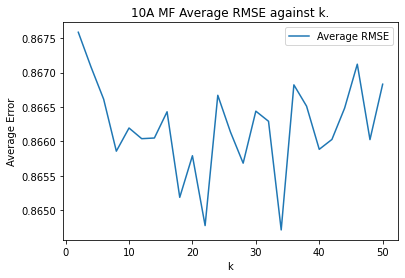

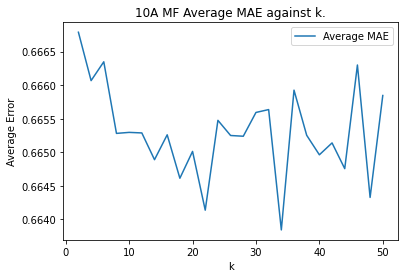

In [29]:
########Question 10
#######Part A

new_ks = np.arange(2,52,2) 
average_rmse = []
average_mae = []
minimum_rmse = 1e4
minimum_mae = 1e4
k_minimum_rmse = 0
for l in trange(len(new_ks)):
    k = new_ks[l]
    print(k)
    svd = SVD(n_factors = k)
    cv_ = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    average_rmse.append(np.mean(cv_["test_rmse"]))
    if average_rmse[-1] < minimum_rmse:
        minimum_rmse = average_rmse[-1]
        k_minimum_rmse = k

    MAE = np.mean(cv_["tmae"])
    average_mae.append(np.mean(cv_["tmae"]))
    if MAE < minimum_mae:
        minimum_mae = MAE
        k_minimum_mae = k
        
plt.plot(new_ks, average_mae, label="Average MAE")
plt.legend()
plt.title("K against MF Average MAE.")
plt.xlabel("k")
plt.ylabel("Average Error")
plt.show()

plt.plot(new_ks, average_rmse, label="Average RMSE")
plt.legend()
plt.title("K against Average RMSE.")
plt.xlabel("k")
plt.ylabel("Average Error")
plt.show()



In [30]:
print("Question10B")
print(f"RMSE (SVD) = {minimum_rmse:.3f}, k = {k_minimum_rmse}")
print(f" MAE (SVD) = {minimum_mae:.3f}, k = {k_minimum_mae}")

Question10B
Minimum Average RMSE (SVD) = 0.865, k = 34
Minimum Average MAE (SVD) = 0.664, k = 34


In [ ]:
#######10c 
#same as 8c
def min_k(title, avg_rmse, ks):
    best_k = -1
    eps = 1e-3
    for i in range(len(ks)-1):
        if((abs(avg_rmse[i]-avg_rmse[i+1])<eps)):
            print(f"{title} Minimum k for RMSE is {ks[i]}, average RMSE is {avg_rmse[i]:.3f}")
            best_k = ks[i]
            break
    return best_k
kf = KFold(n_splits=10)
ref = defaultdict(list)
for _, row in ratings.iterrows():
    ref[row['movieId']].append(row['rating'])
#unpopular trimming part
def unpopular_trim(row):
    return len(ref[row['movieId']]) <= 2
report_result_svd(ratings, unpopular_trim, "Unpopular movie trim", ks=np.arange(2,52,2))

#popular trimming part
def popular_trim(row):
    return len(ref[row['movieId']]) > 2
report_result_svd(ratings, popular_trim, "Popular movie trim", ks=np.arange(2,52,2))


#high variance trimming part
data_df = ratings.pivot_table('rating', 'userId', 'movieId')
variance = np.var(data_df, axis=0)
def high_variance_trim(row):
    return len(ref[row['movieId']]) >= 5 and row['movieId'] in variance[variance>=2].keys()
report_result_svd(ratings, high_variance_trim, "High variance movie trim", ks=np.arange(2,52,2))

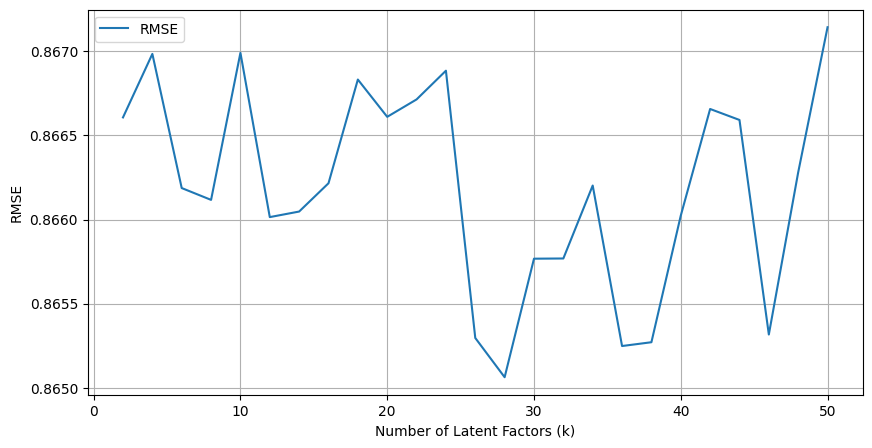

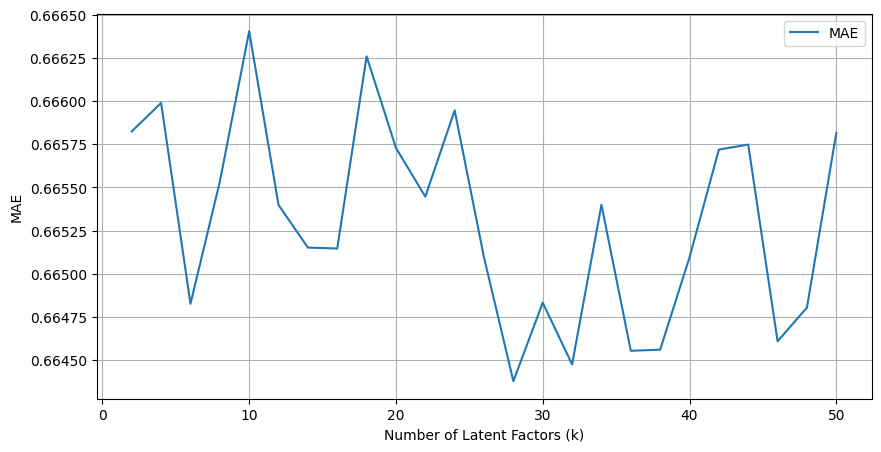

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import random
import nltk
import multiprocessing
import umap.umap_ as umap
import umap.plot
import re
import string
import warnings
import torch

from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
import pandas as pd
L = pd.read_csv("Synthetic_Movie_Lens/links.csv")
M = pd.read_csv("Synthetic_Movie_Lens/movies.csv")
R = pd.read_csv("Synthetic_Movie_Lens/ratings.csv")
T = pd.read_csv("Synthetic_Movie_Lens/tags.csv")

from surprise import KNNWithMeans, NMF, SVD
from sklearn.metrics import roc_curve, auc

# Reader for surprise library
reader = Reader(rating_scale=(0.5, 5))

# Load your dataset in the surprise dataset format
data = Dataset.load_from_df(R[['userId', 'movieId', 'rating']], reader)

# Train-Test split
trainset, testset = train_test_split(data, test_size=.25)

# Group the ratings data by 'movieId'.
grouped = R.groupby('movieId')['rating']

# Get the number of ratings and the variance of ratings for each movie.
rating_counts = grouped.count()
rating_variances = grouped.var()

# Define your subsets.
popular_movies = rating_counts[rating_counts > 2].index
unpopular_movies = rating_counts[rating_counts <= 2].index
high_variance_movies = rating_counts[(rating_counts >= 5) & (rating_variances >= 2)].index

# Trim your ratings data to create the subsets.
popular_ratings = R[R['movieId'].isin(popular_movies)]
unpopular_ratings = R[R['movieId'].isin(unpopular_movies)]
high_variance_ratings = R[R['movieId'].isin(high_variance_movies)]

import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# Your data loading code here...

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(R[['userId', 'movieId', 'rating']], reader)

rmse_scores = []
mae_scores = []

k_values = list(range(2, 51, 2))

# Use SVD algorithm to create collaborative filter and compute RMSE and MAE
for k in k_values:
    algo = SVD(n_factors=k)
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    
    rmse_scores.append(np.mean(cv_results['test_rmse']))
    mae_scores.append(np.mean(cv_results['test_mae']))

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_scores, label='RMSE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

# Plot MAE scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, mae_scores, label='MAE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()



Minimum average RMSE for Popular Movies: 0.8559736763101101 at k=28


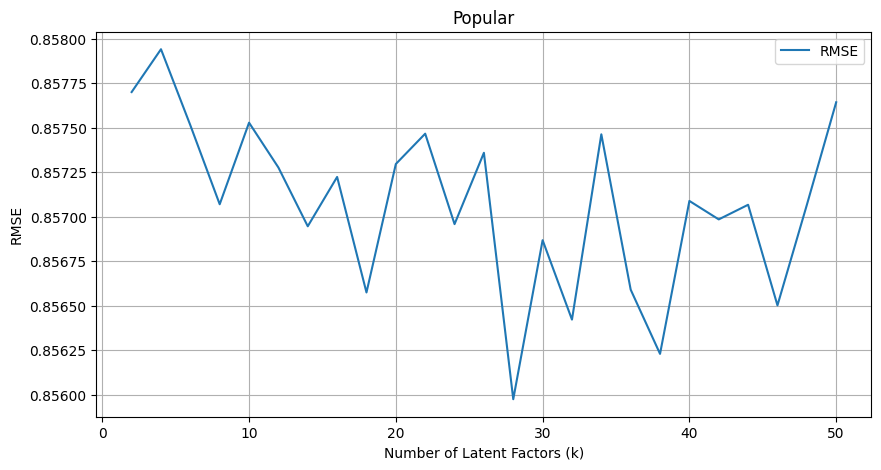

Minimum average RMSE for Unpopular Movies: 0.8953782187726456 at k=26


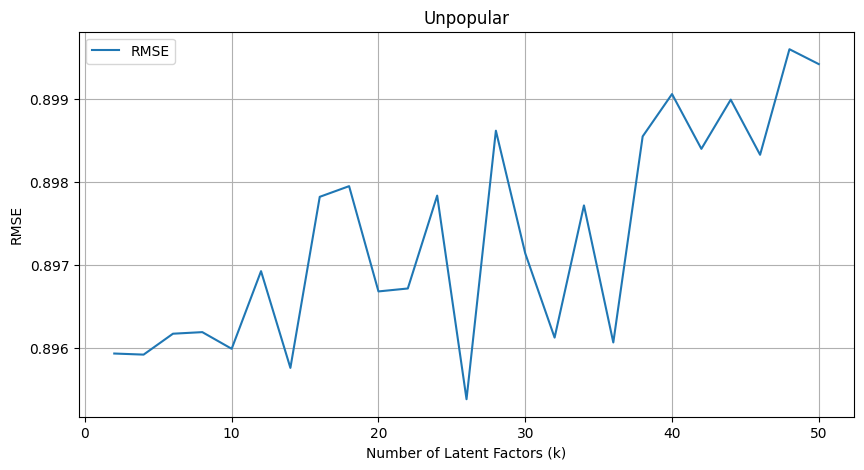

Minimum average RMSE for High Variance Movies: 1.408610837748291 at k=30


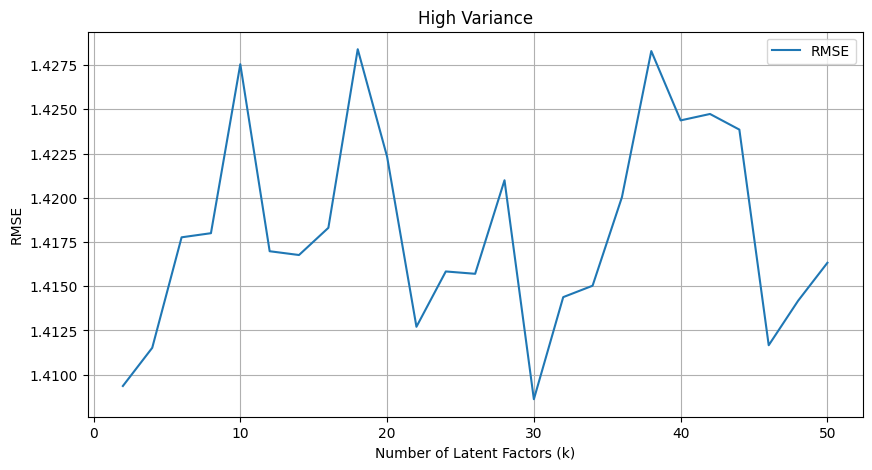

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Define a function to perform cross validation for a given dataset and plot the RMSE
def cross_validate_and_plot(data, title):
    rmse_scores = []
    k_values = list(range(2, 51, 2))

    for k in k_values:
        algo = SVD(n_factors=k)
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=False)
        rmse_scores.append(np.mean(cv_results['test_rmse']))
    
    min_rmse_k = k_values[rmse_scores.index(min(rmse_scores))]
    print(f'Minimum average RMSE for {title} Movies: {min(rmse_scores)} at k={min_rmse_k}')

    plt.figure(figsize=(10, 5))
    plt.plot(k_values, rmse_scores, label='RMSE')
    plt.title(title)
    plt.xlabel('Number of Latent Factors (k)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()

# Load your subsets in the surprise dataset format
popular_data = Dataset.load_from_df(popular_ratings[['userId', 'movieId', 'rating']], reader)
unpopular_data = Dataset.load_from_df(unpopular_ratings[['userId', 'movieId', 'rating']], reader)
high_variance_data = Dataset.load_from_df(high_variance_ratings[['userId', 'movieId', 'rating']], reader)

# Cross validate and plot for each subset
cross_validate_and_plot(popular_data, 'Popular')
cross_validate_and_plot(unpopular_data, 'Unpopular')
cross_validate_and_plot(high_variance_data, 'High Variance')


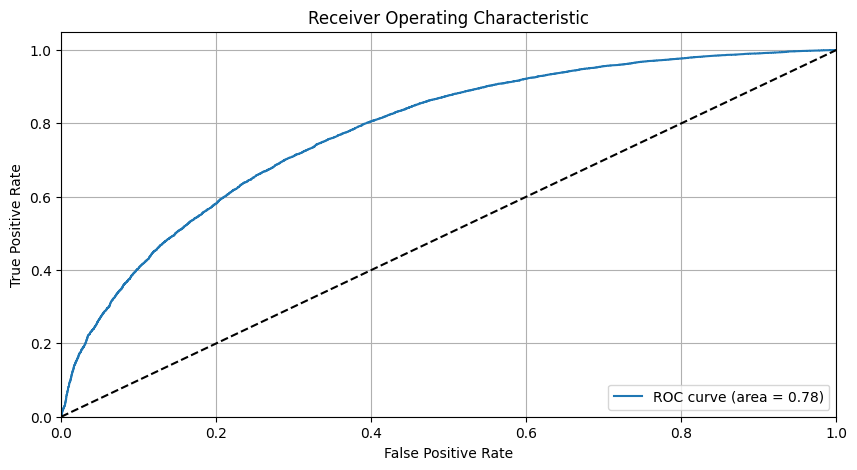

In [3]:
from surprise import accuracy
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Choose your k value. Here, let's use the value that resulted in the minimum average RMSE in the earlier step.
k = 10

algo = SVD(n_factors=k)

# Perform a train-test split
trainset, testset = train_test_split(data, test_size=.25)
algo.fit(trainset)

# Perform the prediction
predictions = algo.test(testset)

# Convert the true ratings into binary format
true_bin = [1 if rating >= 3.5 else 0 for rating in np.array([pred.r_ui for pred in predictions])]

# Get the predicted ratings directly
pred = np.array([pred.est for pred in predictions])

# Compute false positive rate, true positive rate
fpr, tpr, _ = roc_curve(true_bin, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()
